Fuzzy Rules Prediction for Energy Prices
------------------------------------------
Thomas Steinmann & Nidhi Makwana

This script contains three different approaches to predicting energy prices using fuzzy rules. We compare custom membership functions created using statistical analysis to with automatic, simplified ones for all inputs & outputs. We also compare rule sets created by statistical analysis and evloutionary techniques respectively.

First let us define imports as well as a helper method used for printing.

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
"""
Created on Mon Apr  9 12:09:26 2018

@author: 19591676
"""

import sys
import numpy as np
from copy import deepcopy
from datetime import datetime
from random import choice
from skfuzzy import control as ctrl, trimf, interp_membership
import matplotlib.pyplot as plt

# Print helper method
def print_inplace(text, percentage, time_taken=None, comment=""):
        percentage = int(percentage)
        length_factor = 5
        progress_bar = int(round(percentage/length_factor)) * "*" + (round((100-percentage)/length_factor)) * "."
        progress_bar = progress_bar[:round(len(progress_bar)/2)] + "|" + str(int(percentage)) + "%|" + progress_bar[round(len(progress_bar)/2):]
        sys.stdout.write("\r%s |%s|" % (text, progress_bar) + (" Time: %s" % str(time_taken).split(".")[0] if time_taken else "") + comment)
        sys.stdout.flush()

        if percentage == 100:
            print()



Then we define helper methods used for data loading and preprocessing

In [2]:
import csv
import numpy as np
from copy import deepcopy

def load_data(path):
    """
    Returns a dictionary containing the following values: t_2, t_1, t, d_2, d_1, d, p
    """
    t_2, t_1, t = [], [], []
    d_2, d_1, d = [], [], []
    p = []
    
    with open(path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            t_2.append(float(row['T(t-2)']))
            t_1.append(float(row['T(t-1)']))
            t.append(float(row['T(t)']))
            d_2.append(float(row['D(t-2)']))
            d_1.append(float(row['D(t-1)']))
            d.append(float(row['D(t)']))
            p.append(float(row['P(t+1)']))
            
    return {'t_2': t_2, 't_1': t_1, 't': t, 'd_2': d_2, 'd_1': d_1, 'd': d, 'p': p}        

def load_training_data():
    """
    Returns a dictionary containing the following values: t_2, t_1, t, d_2, d_1, d, p
    """
    return load_data('./data/2018_CI_Assignment_Training_Data.csv')

def load_test_data():
    """
    Returns a dictionary containing the following values: t_2, t_1, t, d_2, d_1, d, p
    """
    return load_data('./data/2018_CI_Assignment_Testing_Data.csv')

def remove_outliers(x):
    x = deepcopy(x)
    Q1 = np.percentile(x, 25)
    Q3 = np.percentile(x, 75)
    range = [Q1-1.5*(Q3-Q1),Q3+1.5*(Q3-Q1)]
    positions = np.concatenate((np.where(x>range[1]),np.where(x<range[0])),axis=1)[0]
    outliers = np.take(x, positions)
    if len(outliers) > 0:
        print('Removed outliers: \n%s' % outliers)
    return np.delete(x, positions), positions

def remove_outliers_from_dataset(data):
    """ Removes the outliers from an entire dataset using other low level helper methods """
    data = deepcopy(data)
    
    positions = set()
    for key in data:
        d, pos = remove_outliers(data[key])
        positions.update(pos)
    
    for key in data:
        data[key] = np.delete(data[key], list(positions))
    
    return data


Using the just defined methods we load the training and test data and remove outliers from both data sets
The distribution of the data sets after preprocessing is visualized and plotted below

Removed outliers: 
[ 64.85  72.77  95.09 103.77  97.24  69.41 155.25  55.3   59.61 101.08
 101.74 196.34 276.91 460.29 156.48 153.28 323.31  80.21  52.4   54.6
  54.69  52.18  58.32  56.47  71.13 144.21 187.   274.49 274.7   62.48
  71.91 183.76 109.23  64.6   55.71  79.26 216.23  59.87  84.36  80.19
  54.32  55.05 273.72  62.06  98.49 188.27  62.18  59.81  72.24  52.56
  55.95  54.8   53.5   54.07  55.4 ]
Removed outliers: 
[ 59.53  63.49 102.73 162.74 213.1  134.67 192.36 128.53 127.75 131.21
 213.88  99.3   99.3   59.32  56.08  59.05  58.03  58.13  60.12  56.34
 138.32]


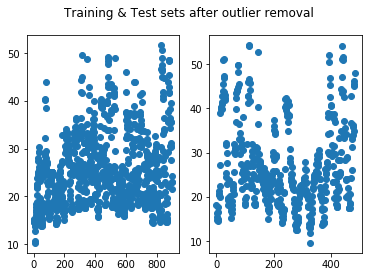

In [3]:
""" Data loading and preprocessing """
training_data = load_training_data()
training_data = remove_outliers_from_dataset(training_data)

plt.subplot(121)
plt.plot(training_data['p'], 'o')
plt.suptitle('Training & Test sets after outlier removal')

test_data = load_test_data()
test_data = remove_outliers_from_dataset(test_data)

plt.subplot(122)
plt.plot(test_data['p'], 'o')
plt.show()

Next we compute and plot a correlation matrix in order to determine which input values correlate to eachother.
This analysis shows two groups of inputs that are highly correlated within their respective groups but not to the other group.
We choose the two inputs that are most correlated to the output in each group and therefore not highly correlated to each other.

Correlation Coefficients Matrix Values: 
[[1.         0.97711422 0.94083427 0.43523077 0.49341031 0.54010843
  0.49325377]
 [0.97711422 1.         0.97678556 0.37103657 0.43915887 0.49715253
  0.46219849]
 [0.94083427 0.97678556 1.         0.29729518 0.37354107 0.44142236
  0.41799108]
 [0.43523077 0.37103657 0.29729518 1.         0.98603698 0.9497314
  0.52955784]
 [0.49341031 0.43915887 0.37354107 0.98603698 1.         0.98603361
  0.56492116]
 [0.54010843 0.49715253 0.44142236 0.9497314  0.98603361 1.
  0.5877078 ]
 [0.49325377 0.46219849 0.41799108 0.52955784 0.56492116 0.5877078
  1.        ]]


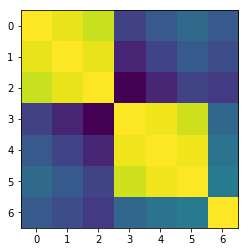

In [4]:
""" Correlation matrix """
# TODO: This could be automated
trainingA = np.row_stack((training_data['t_2'], training_data['t_1'], training_data['t'],
                          training_data['d_2'], training_data['d_1'], training_data['d'],
                          training_data['p']))

correlationCoefficients = np.corrcoef(trainingA)
fig = plt.figure()
ax = fig.add_subplot(111)
print('Correlation Coefficients Matrix Values: \n%s' % correlationCoefficients)
ax.imshow(correlationCoefficients, interpolation='nearest')
plt.show()

# Choose t-2, d and p for data set
trainingA = np.row_stack((training_data['t_2'], training_data['d'], training_data['p']))


In order to determine the form of the membership functions we draw histograms for each input of the test set and mimick the membership functions to have a similar form.

C:\Program Files\Anaconda\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


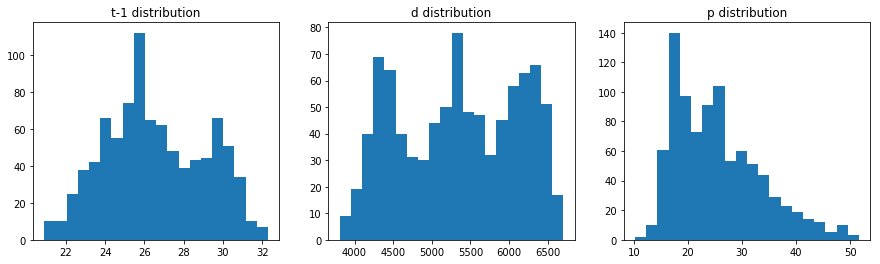

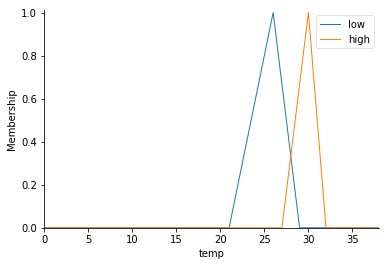

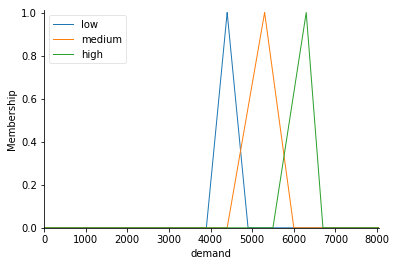

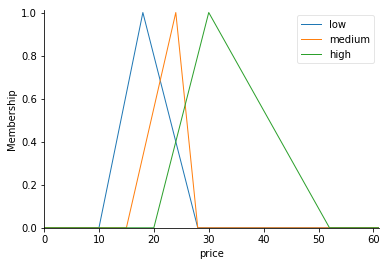

In [5]:
""" Fuzzy membership function definitions """
fig = plt.figure()
fig.set_figwidth(15)
ax = fig.add_subplot(131)
ax.hist(training_data['t_1'], 20)
ax.set_title('t-1 distribution')

ax = fig.add_subplot(132)
ax.hist(training_data['d'], 20)
ax.set_title('d distribution')

ax = fig.add_subplot(133)
ax.hist(training_data['p'], 20)
ax.set_title('p distribution')

temp = ctrl.Antecedent(np.arange(0, max(training_data['t_2'])*1.2, 1), 'temp')
temp_low = trimf(temp.universe, [21, 26, 29])
temp['low'] = temp_low
temp_high = trimf(temp.universe, [27, 30, 32])
temp['high'] = temp_high
temp.view()

demand = ctrl.Antecedent(np.arange(0, max(training_data['d'])*1.2, 1), 'demand')
demand_low = trimf(demand.universe, [3900, 4400, 4900])
demand['low'] = demand_low
demand_mid = trimf(demand.universe, [4400, 5300, 6000])
demand['medium'] = demand_mid
demand_high = trimf(demand.universe, [5500, 6300, 6700])
demand['high'] = demand_high
demand.view()

price = ctrl.Consequent(np.arange(0, max(training_data['p'])*1.2, 1), 'price')
price_low = trimf(price.universe, [10, 18, 28])
price['low'] = price_low
price_medium = trimf(price.universe, [15, 24, 28])
price['medium'] = price_medium
price_high = trimf(price.universe, [20, 30, 52])
price['high'] = price_high
price.view()

Finally we statistically analyse the support each possible rule gets from the training set. For this we draw a three dimensional array, one for each input/ output. We then compute the maximal degree of membership for each input value of the training set and sum up the max_membership values.

When plotting this array we can read out and select the rules with the most support from the test data set.

[[[192, 62, 45], [14, 7, 8]], [[22, 77, 64], [5, 18, 25]], [[8, 102, 44], [2, 63, 143]]]


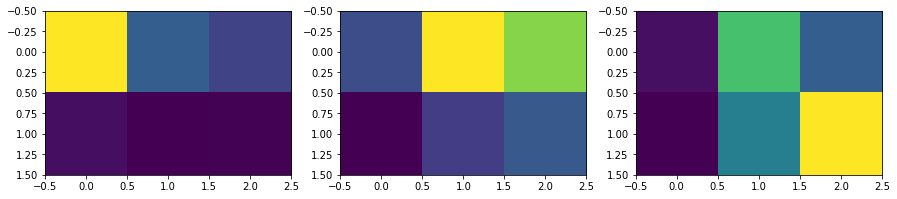

In [6]:
""" Statistical Analysis """
grid = [[[0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0]]]

for t, d, p in zip(training_data['t_2'], training_data['d'], training_data['p']):
    t = max((interp_membership(temp.universe, temp_low, t), 0), (interp_membership(temp.universe, temp_high, t), 1))[1]
    d = max((interp_membership(demand.universe, demand_low, d), 0), (interp_membership(demand.universe, demand_mid, d), 1), (interp_membership(demand.universe, demand_high, d), 2))[1]
    p = max((interp_membership(price.universe, price_low, p), 0), (interp_membership(price.universe, price_medium, p), 1), (interp_membership(price.universe, price_high, p), 2))[1]
    grid[p][t][d] += 1

print(grid)
fig = plt.figure()
fig.set_figwidth(15)
ax = fig.add_subplot(131)
ax.imshow(grid[0], interpolation='nearest')
ax = fig.add_subplot(132)
ax.imshow(grid[1], interpolation='nearest')
ax = fig.add_subplot(133)
ax.imshow(grid[2], interpolation='nearest')
plt.show()

""" Fuzzy rules definitions """
# High support rules
rules = []
rules.append(ctrl.Rule(temp['low'] | demand['low'], price['low']))
rules.append(ctrl.Rule(temp['low'] | demand['medium'], price['medium']))
rules.append(ctrl.Rule(temp['high'] | demand['high'], price['high']))

# Medium support rules
#rules.append(ctrl.Rule(temp['low'] | demand['high'], price['medium']))
#rules.append(ctrl.Rule(temp['low'] | demand['medium'], price['high']))

Finally we build our simulation using the chosen rules and evaluate it against both the training and the test set

In [7]:
""" Build and evaluate simulation """
    
def evaluate_simulation(simulation, evaluation_dataset):
    error = 0
    for t2, d, p in zip(evaluation_dataset["t_2"], evaluation_dataset["d"], evaluation_dataset["p"]):
        simulation.input["temp"] = t2
        simulation.input["demand"] = d
        simulation.compute()
        error += abs((simulation.output['price'] + p)/p)
        
    return error/len(evaluation_dataset['p'])

control_system = ctrl.ControlSystem(rules)
simulation = ctrl.ControlSystemSimulation(control_system)

print('Average training error: %s' % evaluate_simulation(simulation, training_data))
print('Average test error: %s' % evaluate_simulation(simulation, test_data))

Average training error: 2.0611827131658953
Average test error: 2.1155442125039934


Compare this to automatically computed membership functions

C:\Program Files\Anaconda\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


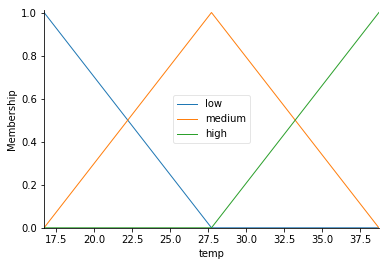

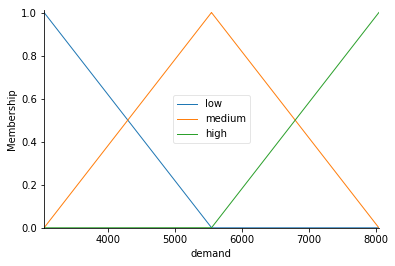

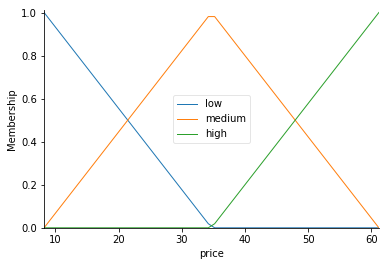

In [8]:
auto_temp = ctrl.Antecedent(np.arange(min(training_data['t_2'])*0.8, max(training_data['t_2'])*1.2, 1), 'temp')
auto_temp.automf(3, names=['low', 'medium', 'high'])
auto_temp.view()

auto_demand = ctrl.Antecedent(np.arange(min(training_data['d'])*0.8, max(training_data['d'])*1.2, 1), 'demand')
auto_demand.automf(3, names=['low', 'medium', 'high'])
auto_demand.view()

auto_price = ctrl.Consequent(np.arange(min(training_data['p'])*0.8, max(training_data['p'])*1.2, 1), 'price')
auto_price.automf(3, names=['low', 'medium', 'high'])
auto_price.view()

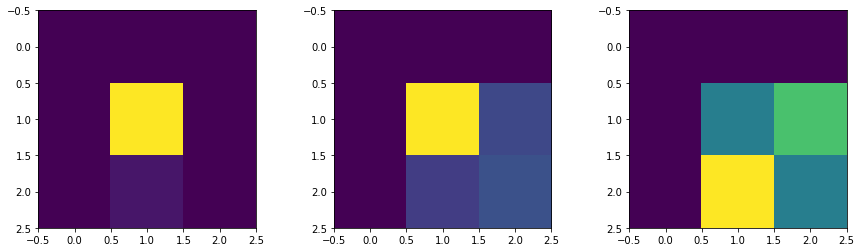

In [9]:
# These values are based on the automatically generated membership functions
grid = [[[0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0]]]
for t, d, p in zip(training_data['t_2'], training_data['d'], training_data['p']):
    t = min((abs(t-0), 0), (abs(t-19), 1), (abs(t-38), 2))[1]
    d = min((abs(d-0), 0), (abs(d-4000), 1), (abs(d-8000), 2))[1]
    p = min((abs(p-0), 0), (abs(p-30), 1), (abs(p-61), 2))[1]
    grid[p][t][d] += 1
    
fig = plt.figure()
fig.set_figwidth(15)
ax = fig.add_subplot(131)
ax.imshow(grid[0], interpolation='nearest')
ax = fig.add_subplot(132)
ax.imshow(grid[1], interpolation='nearest')
ax = fig.add_subplot(133)
ax.imshow(grid[2], interpolation='nearest')
plt.show()

This makes for a slightly different rules and slightly weaker prediction accuracy accordingly.

In [10]:
auto_rules = []
auto_rules.append(ctrl.Rule(auto_temp['medium'] | auto_demand['medium'], auto_price['low']))
auto_rules.append(ctrl.Rule(auto_temp['medium'] | auto_demand['medium'], auto_price['medium']))
auto_rules.append(ctrl.Rule(auto_temp['high'] | auto_demand['medium'], auto_price['high']))
auto_rules.append(ctrl.Rule(auto_temp['medium'] | auto_demand['high'], auto_price['high']))


control_system = ctrl.ControlSystem(auto_rules)
simulation = ctrl.ControlSystemSimulation(control_system)

print('Average training error: %s' % evaluate_simulation(simulation, training_data))
print('Average test error: %s' % evaluate_simulation(simulation, test_data))

Average training error: 2.4930123578619443
Average test error: 2.4522036523653927


Discussion I
-------------
This implementation showcases the importance of proper membership function design for prediction accuracy. Even with simple analysis of the training data and according adjustment of membership functions the prediction accuracy can be signifficantly improved.


Evolutionary rule selection
----------------------------

In the following we use an evolutionary approach to search the rule space and continuously improves the rule base. The same handcrafted membership functions from the previous implementation are used so this implementation merely demonstrates an alternative way of determining the rule base. Ideally the membership function generation would be automated in a similar way to what we did manually in this project. This would allow us to search a wider space of both membership functions and their respective rules and give the system more capacity to adapt to the problem.

#### Rule Selection ####
We start with an original rule population represented as a binary vector. The fuzzy API requires at least two rules that cover a wide range of possible input values for this setup. We made the reasonable assumption that if both temperature and demand would be high or low, the price would follow which is represented by the first and last rule of the rule population respectively.

The Optimization algorithm then adds each yet inactive rule seperately and analyzes the system's performance. The best performing rule is permanently added to to the population. This process is repeated ADD times and after that REMOVE times in the opposite direction, which means REMOVE rules are removed from the population based on performance analysis where ADD and REMOVE are integer constants.

The above describes one search through the size of the population. After this the ADD and REMOVE constants can be changed in order to search a different part of the search space. There are many different possibilities to try out here, such as searching from the previous best population, searching from scratch, random ADD and REMOVE constants, etc. In the interest of time and resources we only implemented a minimal version.

In [11]:
""" Fuzzy rules definitions """
# create all possible rules
allRules = []
for tmp_name in ['low', 'high']:
    for dem_name in ['low', 'medium', 'high']:
        for out_name in ['low', 'medium', 'high']:
            allRules.append(ctrl.Rule(temp[tmp_name] | demand[dem_name], price[out_name]))

TOTAL_FEATURES = 2 * 3 * 3
ITERATIONS = TOTAL_FEATURES // 2

def build_simulation(rule_indices):
    rules = [rule for rule, selected in zip(allRules, rule_indices) if selected]
    control_system = ctrl.ControlSystem(rules)
    return ctrl.ControlSystemSimulation(control_system)

def evaluate_population(pop, evaluation_dataset):
    simulation = build_simulation(pop)
    try:
        return evaluate_simulation(simulation, evaluation_dataset)
    except:
        return 10000
    

def mutate(pop, index, direction):
    """ Mutates(flips) each gene and evaluates it. Returns a tuple (accuracy, population) """
    # print_inplace('Mutation %s/%s' % (index, len(pop)), index/len(pop)*100, time_taken=datetime.now()-start)
    new_pop = list(deepcopy(pop))
    
    if new_pop[index] != direction:             # Mutate if not already active
        new_pop[index] = direction
        return evaluate_population(new_pop, training_data), new_pop
    
    return 100000, new_pop                     # Return -1 accuracy if mutation was not performed

For the defuzzyfication to work we need at least two rules, covering enough of the rule space. We choose all low and all high from expert knowledge as a reasonable initialization. These initial rules can be unselected by the process later on.

In [12]:
start = datetime.now()

# Generate initial population
population = [False for i in range(TOTAL_FEATURES)]
population[0], population[-1] = True, True
# population[len(population) // 2] = True
best_population = evaluate_population(population, training_data), deepcopy(population)

ADD = 2
REMOVE = 1
PASSES = 2
for i in range(PASSES):
    print('Search pass through rule space no. %s/%s' % (+1, PASSES))
    for i in range(ITERATIONS):

        # Add Rules
        for takes in range(ADD):
            error, population = min([mutate(population, index, True) for index in range(len(population))])
            
            # print(error, population)
            
            # Save best performing
            if error < best_population[0]:
                best_population = error, deepcopy(population)

        # Remove Rules
        for takes in range(REMOVE):
            error, population = min([mutate(population, index, False) for index in range(len(population))])
            
            # print(error, population)
            
            # Save best performing
            if error < best_population[0]:
                best_population = error, deepcopy(population)
        
        print_inplace('Feature selection iteration %s/%s' % (i+1, ITERATIONS), (i+1)/ITERATIONS*100, time_taken=datetime.now()-start, comment=' | Best Population: Average Error: %s, population: %s' % (abs(best_population[0]), best_population[1]))
    
    print('Switch search direction')
    ADD, REMOVE = REMOVE+1, ADD+1
    

print('\n| --- Evaluation --- |')
print("Best Population:")
print(best_population[1])
print('Average error on training set: %s' % abs(evaluate_population(best_population[1], training_data)))

# Evaluate best population on testset
print('Average error on test set: %s' % abs(evaluate_population(best_population[1], test_data)))

Search pass through rule space no. 1/2
Feature selection iteration 9/9 |**********|100%|**********| Time: 0:02:17 | Best Population: Average Error: 1.8044088286676094, population: [True, False, False, False, False, False, False, False, False, True, False, False, True, False, False, True, False, False]
Switch search direction
Search pass through rule space no. 1/2
Feature selection iteration 9/9 |**********|100%|**********| Time: 0:05:55 | Best Population: Average Error: 1.8044088286676094, population: [True, False, False, False, False, False, False, False, False, True, False, False, True, False, False, True, False, False]
Switch search direction

| --- Evaluation --- |
Best Population:
[True, False, False, False, False, False, False, False, False, True, False, False, True, False, False, True, False, False]
Average error on training set: 1.8044088286676094
Average error on test set: 1.7823246832627635


Discussion II
--------------

The accuracy improves rather quickly during training and the final performance is significantly better than the statistical approach which uses the same membership functions. We assume further gains with greater capacity (membership functions) and searched space. Both of these could easily be improved using the existing implementation but cannot be reasonably tested without access to more convenient resources such as a cluster node that could be run overnight.